## Introduction
* use mean imputer
* use ECG data (all scaled ECG)
* concat training

## Setup

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
!pip install -q transformers

In [50]:
# !unzip -qq /content/drive/MyDrive/'Colab Notebooks'/projects/etc/MAIC/'심전도 데이터를 활용한 나이 예측'/dataset/MAIC_data/kaggle_additional_data.zip

In [51]:
GLOBAL_SEED = 42

import os
os.environ['PYTHONHASHSEED'] = str(GLOBAL_SEED)

import numpy as np # linear algebra
from numpy import random as np_rnd
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import random as rnd
import pickle
import gc
import time
from itertools import product

from torch.utils.data import TensorDataset, Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from transformers import get_polynomial_decay_schedule_with_warmup
from scipy.signal import spectrogram

from sklearn import metrics as skl_metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings(action='ignore')
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [52]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    # python random
    rnd.seed(seed)
    # numpy random
    np_rnd.seed(seed)
    # RAPIDS random
    try:
        cupy.random.seed(seed)
    except:
        pass
    # tf random
    try:
        tf_rnd.set_seed(seed)
    except:
        pass
    # pytorch random
    try:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    except:
        pass

def pickleIO(obj, src, op="r"):
    if op=="w":
        with open(src, op + "b") as f:
            pickle.dump(obj, f)
    elif op=="r":
        with open(src, op + "b") as f:
            tmp = pickle.load(f)
        return tmp
    else:
        print("unknown operation")
        return obj

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print('Error: Creating directory. ' + directory)

def findIdx(data_x, col_names):
    return [int(i) for i, j in enumerate(data_x) if j in col_names]

def diff(first, second):
    second = set(second)
    return [item for item in first if item not in second]

In [53]:
class CFG:
    debug = False
    dataset_root_path = r"/content/drive/MyDrive/Colab Notebooks/projects/etc/MAIC/심전도 데이터를 활용한 나이 예측/dataset/MAIC_data/"
    dataset_version = "v5"
    n_comp = 64
    TF = False
    TF_type = "indiv"
    use_ecg_stats = True
    use_ecg_seq = True
    pca_seq = True
    n_folds = 1 if debug else 5
    lead_names = ["std1", "std2", "std3", "v1", "v2", "v3", "v4", "v5", "v6", "augvr", "augvl", "augvf"]
    ecg_hz = 500

    epochs = 2 if debug else 30
    early_stopping_rounds = 10
    batch_size = 32
    eta = 5e-4
    weight_decay = 1e-4

In [54]:
prep_root_path = r"/content/drive/MyDrive/Colab Notebooks/projects/etc/MAIC/심전도 데이터를 활용한 나이 예측/dataset/prep_data/" + CFG.dataset_version + "/"

## Loading data

In [55]:
df_full = pickleIO(None, prep_root_path + "df_full.pkl", "r")
full_ecg_meta_feature = pickleIO(None, prep_root_path + "df_full_meta.pkl", "r").astype("float32")
full_ecg_seq_feature = np.load(r"/content/drive/MyDrive/Colab Notebooks/projects/etc/MAIC/심전도 데이터를 활용한 나이 예측/dataset/prep_data/" + "v1" + "/" + "full_ecg.npz")["ecg"].astype("float32")
fold_split = np.load(prep_root_path + "fold_split.npz")

In [56]:
full_ecg_meta_feature.shape

(43688, 444)

In [57]:
full_ecg_seq_feature.shape

(43688, 12, 500)

In [58]:
df_full.loc[df_full["age_type"] == "child", "age"].max(), df_full.loc[df_full["age_type"] == "adult", "age"].min()

(8.083333333, 19.0)

### Loading kaggle data


In [59]:
df_kaggle = {"age": [], "gender": [], "ecg": []}

for chunk in range(20):
    tmp = np.load(f"chunk{chunk}.npz")
    for k in df_kaggle.keys():
        df_kaggle[k].append(tmp[k])

del tmp; gc.collect()

619

In [60]:
kaggle_ecg = F.avg_pool1d(torch.from_numpy(np.concatenate(df_kaggle["ecg"]).astype("float32")), 10, 10).detach().cpu().numpy()
df_kaggle = pd.DataFrame({"age": np.concatenate(df_kaggle["age"]), "gender": np.concatenate(df_kaggle["gender"])})
df_kaggle["age_type"] = df_kaggle["age"].apply(lambda x: 1 if x >= 19 else 0)

In [61]:
kaggle_ecg.shape

(80876, 12, 500)

In [62]:
df_kaggle.shape

(80876, 3)

### Preprocessing

In [63]:
df_full["gender"] = df_full["gender"].apply(lambda x: 1 if x == "MALE" else 0).astype("int32")
df_full["age_type"] = df_full["age_type"].apply(lambda x: 1 if x == "adult" else 0).astype("int32")
df_full = df_full.drop("filename", axis=1)

In [64]:
df_full["fold"] = fold_split["fold_split"].astype("float32")
df_full["fold_adult"] = -1; df_full["fold_child"] = -1
df_full.loc[df_full["age_type"] == 1, "fold_adult"] = fold_split["adult"].astype("float32")
df_full.loc[df_full["age_type"] == 0, "fold_child"] = fold_split["child"].astype("float32")

In [65]:
df_full.shape

(43688, 6)

In [66]:
df_full

,gender,age,age_type,fold,fold_adult,fold_child
0,1,53.000000,1,0.0,2,-1
1,1,68.000000,1,1.0,0,-1
2,1,68.000000,1,0.0,0,-1
3,1,89.000000,1,1.0,0,-1
4,1,79.000000,1,1.0,2,-1
...,...,...,...,...,...,...
43683,1,0.666667,0,2.0,-1,0
43684,1,0.083333,0,4.0,-1,3
43685,0,5.833333,0,0.0,-1,1
43686,0,2.250000,0,2.0,-1,4


### Merging with kaggle data

In [67]:
df_full = pd.concat([df_full, df_kaggle], axis=0)
full_ecg_seq_feature = np.concatenate([full_ecg_seq_feature, kaggle_ecg])
del df_kaggle, kaggle_ecg; gc.collect()

0

In [68]:
df_full[["age", "fold_adult", "fold_child"]] = df_full[["age", "fold_adult", "fold_child"]].astype("float32")
df_full["age_type"] = df_full["age_type"].astype("int32")

In [69]:
full_ecg_seq_feature = full_ecg_seq_feature[df_full["age"] > 0]
df_full = df_full[df_full["age"] > 0].reset_index(drop=True)

In [70]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124316 entries, 0 to 124315
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   gender      124316 non-null  int32  
 1   age         124316 non-null  float32
 2   age_type    124316 non-null  int32  
 3   fold        43688 non-null   float32
 4   fold_adult  43688 non-null   float32
 5   fold_child  43688 non-null   float32
dtypes: float32(4), int32(2)
memory usage: 2.8 MB


In [71]:
df_full.shape

(124316, 6)

In [72]:
full_ecg_seq_feature.shape

(124316, 12, 500)

In [73]:
scaler_seq = {}
for target in df_full["age_type"].unique():
    scaler_seq[target] = {}
    tmp = full_ecg_seq_feature[df_full["age_type"] == target]
    for i in range(len(CFG.lead_names)):
        scaler_seq[target][i] = {"min": 0.0, "max": 0.0}
        scaler_seq[target][i]["min"] = tmp[:, i].min()
        scaler_seq[target][i]["max"] = tmp[:, i].max()
        tmp[:, i] = (tmp[:, i] - scaler_seq[target][i]["min"]) / (scaler_seq[target][i]["max"] - scaler_seq[target][i]["min"])
    full_ecg_seq_feature[df_full["age_type"] == target] = tmp.copy()

### Assign fold & Remove outlier

In [74]:
imputer_cols = [i for i in df_full if i not in ["age_type", "age", "fold", "fold_adult", "fold_child"]]

imputer = {}
for target in df_full["age_type"].unique():
    imputer[target] = df_full.loc[df_full["age_type"] == target, imputer_cols].median()
    for i in df_full.columns:
        if i in ["age_type", "age", "fold", "fold_adult", "fold_child"]:
            continue
        if df_full.loc[df_full["age_type"] == target, i].isna().sum() > 0:
            df_full.loc[(df_full["age_type"] == target) & df_full[i].isna(), i] = imputer[target][i]

In [75]:
df_full = df_full[full_ecg_seq_feature.sum(axis=(1,2)) != 0].reset_index(drop=True)
full_ecg_seq_feature = full_ecg_seq_feature[full_ecg_seq_feature.sum(axis=(1,2)) != 0]

In [76]:
# assert df_full.isna().sum().sum() == 0

In [77]:
full_ecg_seq_feature.shape

(124316, 12, 500)

In [78]:
df_full.shape

(124316, 6)

In [79]:
df_full

,gender,age,age_type,fold,fold_adult,fold_child
0,1,53.0,1,0.0,2.0,-1.0
1,1,68.0,1,1.0,0.0,-1.0
2,1,68.0,1,0.0,0.0,-1.0
3,1,89.0,1,1.0,0.0,-1.0
4,1,79.0,1,1.0,2.0,-1.0
...,...,...,...,...,...,...
124311,1,58.0,1,NaN,NaN,NaN
124312,1,77.0,1,NaN,NaN,NaN
124313,1,74.0,1,NaN,NaN,NaN
124314,0,58.0,1,NaN,NaN,NaN


## Define model & Training

In [80]:
class group_minmax():
    def __init__(self):
        self.scaler = {}
    def fit(self, x, groups):
        for group in np.unique(groups):
            self.scaler[group] = {
                "max": (x[groups == group]).max(),
                "min": (x[groups == group]).min(),
            }
    def transform(self, x, groups):
        output = np.zeros_like(x)
        for group in np.unique(groups):
            output[groups == group] = (x[groups == group] - self.scaler[group]["min"]) / (self.scaler[group]["max"] - self.scaler[group]["min"])
        return output
    def fit_transform(self, x, groups):
        for group in np.unique(groups):
            self.scaler[group] = {
                "max": (x[groups == group]).max(),
                "min": (x[groups == group]).min(),
            }
        output = np.zeros_like(x)
        for group in np.unique(groups):
            output[groups == group] = (x[groups == group] - self.scaler[group]["min"]) / (self.scaler[group]["max"] - self.scaler[group]["min"])
        return output
    def inverse_transform(self, x, groups):
        output = np.zeros_like(x)
        for group in np.unique(groups):
            output[groups == group] = (x[groups == group] * (self.scaler[group]["max"] - self.scaler[group]["min"])) + self.scaler[group]["min"]
        return output


def get_optimizer_params(model, eta, weight_decay):
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        # apply weight decay
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
         'lr': eta, 'weight_decay': weight_decay},
        # don't apply weight decay for LayerNormalization layer
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
         'lr': eta, 'weight_decay': 0.0},
    ]
    return optimizer_parameters


def get_scheduler(optimizer, num_warmup_steps, num_training_steps):
    scheduler = get_polynomial_decay_schedule_with_warmup(
        optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps, power=0.5, lr_end=1e-7
    )
    return scheduler


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

In [81]:
def train_fn(model, dl, criterion, optimizer, scheduler, grad_scaler):
    model.train()
    metrics = {
        "loss": AverageMeter("loss", fmt=":.5f"),
        "mae": AverageMeter("loss", fmt=":.5f"),
    }

    for idx, batch in enumerate(dl):
        batch = {k: v.to(device).to(torch.float32) for k, v in batch.items()}
        with torch.cuda.amp.autocast():
            _, output = model(seq=batch["seq"], meta=batch["meta"])
            loss = criterion(output, batch["label"])
        # initialization gradients to zero
        optimizer.zero_grad()
        # get scaled gradients by float16 (default)
        grad_scaler.scale(loss).backward()
        # apply original gradients (unscaling) to parameters
        # if these gradients do not contain infs or NaNs, optimizer.step() is then called.
        # otherwise, optimizer.step() is skipped.
        grad_scaler.step(optimizer)
        grad_scaler.update()
        # calcuate metrics
        metrics["loss"].update(loss.item())
        metrics["mae"].update(skl_metrics.mean_absolute_error(output.flatten().detach().cpu().numpy(), batch["label"].flatten().detach().cpu().numpy()))

        if CFG.debug:
            if idx >= 10:
                break

    # update scheduler
    scheduler.step()

    del idx, batch, output
    gc.collect()
    torch.cuda.empty_cache()
    return metrics

def valid_fn(model, dl, criterion):
    model.eval()
    metrics = {
        "loss": AverageMeter("loss", fmt=":.5f"),
        "mae": AverageMeter("loss", fmt=":.5f"),
    }

    for idx, batch in enumerate(dl):
        batch = {k: v.to(device).to(torch.float32) for k, v in batch.items()}
        with torch.no_grad():
            _, output = model(seq=batch["seq"], meta=batch["meta"])
            loss = criterion(output, batch["label"])
        # calcuate metrics
        metrics["loss"].update(loss.item())
        metrics["mae"].update(skl_metrics.mean_absolute_error(output.flatten().detach().cpu().numpy(), batch["label"].flatten().detach().cpu().numpy()))

    del idx, batch, output
    gc.collect()
    torch.cuda.empty_cache()
    return metrics

In [82]:
def do_training(fold, model, target_name):
    # set loss & optimizer
    optimizer_parameters = get_optimizer_params(
        model,
        eta=CFG.eta,
        weight_decay=CFG.weight_decay
    )
    optimizer = AdamW(optimizer_parameters, lr=CFG.eta, weight_decay=CFG.weight_decay)
    scheduler = get_scheduler(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=CFG.epochs
    )
    grad_scaler = torch.cuda.amp.GradScaler()
    criterion = nn.MSELoss()

    best_score = np.inf
    early_stopping_cnt = 0
    for epoch in range(CFG.epochs):
        epoch_start_time = time.time()

        # training
        train_metrics = train_fn(model, train_dl, criterion, optimizer, scheduler, grad_scaler)
        # evaluation
        valid_metrics = valid_fn(model, valid_dl, criterion)
        score = valid_metrics["mae"].avg

        print("Epoch[{0}/{1}]\n train loss : {2}\n valid loss : {3}\n train mae : {4}\n valid mae : {5}\n eta : {6}\n Elapsed : {7}\n"
              .format(
                  epoch+1, CFG.epochs,
                  round(train_metrics["loss"].avg, 5), round(valid_metrics["loss"].avg, 5),
                  round(train_metrics["mae"].avg, 5), round(valid_metrics["mae"].avg, 5),
                  round(optimizer.param_groups[-1]['lr'], 5), round(time.time() - epoch_start_time, 3)
              )
        )

        if score < best_score:
            best_score = score
            return_score_dic = {
                "fold": fold,
                "train_loss": train_metrics["loss"].avg,
                "valid_loss": valid_metrics["loss"].avg,
                "train_mae": train_metrics["mae"].avg,
                "valid_mae": valid_metrics["mae"].avg,
            }
            print("INFO: Found best weight\n\n")
            torch.save(
                {'model': model.state_dict()},
                f"{architecture_path}model_target{target_name}_fold{fold}_best.pth",
            )
            early_stopping_cnt = 0
        else:
            early_stopping_cnt += 1

        if early_stopping_cnt == CFG.early_stopping_rounds:
            break

    return return_score_dic

In [83]:
class CustomDataset(Dataset):
    def __init__(self, feature_seq, feature_meta, label=None):
        self.feature_seq = feature_seq
        self.feature_meta = feature_meta
        self.label = np.ones(len(feature_seq)) if label is None else label

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return {"seq": self.feature_seq[idx], "meta": self.feature_meta[idx], "label": self.label[idx]}

class PositionalEncoding(nn.Module):
    def __init__(self, max_seq_length=512, d_model=32):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.max_seq_length = max_seq_length
        self.pos_embed_layer = nn.Embedding(max_seq_length, d_model)

    def forward(self, x):
        pos_embed = self.pos_embed_layer(torch.arange(self.max_seq_length, dtype=torch.int64).to(device))
        pos_embed = torch.tile(pos_embed, (len(x), 1, 1))
        return pos_embed

class DenseBlock(nn.Module):
    def __init__(self, in_c, in_out, kernel_size=5, stride=1, act=nn.ReLU()):
        super(DenseBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.BatchNorm1d(in_c),
            act,
            nn.Conv1d(in_c, in_c, kernel_size=1, groups=in_c, padding="same"),
            nn.BatchNorm1d(in_c),
            act,
            nn.Conv1d(in_c, in_out, kernel_size=kernel_size, stride=stride, padding="same"),
        )

        self.conv2 = nn.Sequential(
            nn.BatchNorm1d(in_c + in_out),
            act,
            nn.Conv1d(in_c + in_out, in_c + in_out, kernel_size=1, groups=in_c + in_out, padding="same"),
            nn.BatchNorm1d(in_c + in_out),
            act,
            nn.Conv1d(in_c + in_out, in_out, kernel_size=kernel_size, stride=stride, padding="same"),
        )

        self.conv3 = nn.Sequential(
            nn.BatchNorm1d(in_c + in_out * 2),
            act,
            nn.Conv1d(in_c + in_out * 2, in_c + in_out * 2, kernel_size=1, groups=in_c + in_out * 2, padding="same"),
            nn.BatchNorm1d(in_c + in_out * 2),
            act,
            nn.Conv1d(in_c + in_out * 2, in_out, kernel_size=kernel_size, stride=stride, padding="same"),
        )

        self.conv4 = nn.Sequential(
            nn.BatchNorm1d(in_c + in_out * 3),
            act,
            nn.Conv1d(in_c + in_out * 3, in_c + in_out * 3, kernel_size=1, groups=in_c + in_out * 3, padding="same"),
            nn.BatchNorm1d(in_c + in_out * 3),
            act,
            nn.Conv1d(in_c + in_out * 3, in_out, kernel_size=kernel_size, stride=stride, padding="same"),
        )

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(torch.cat([x, x1], dim=1))
        x3 = self.conv3(torch.cat([x, x1, x2], dim=1))
        x4 = self.conv4(torch.cat([x, x1, x2, x3], dim=1))
        return x4

class TransitionLayer(nn.Module):
    def __init__(self, pool_size):
        super(TransitionLayer,self).__init__()
        self.pooling = nn.AvgPool1d(kernel_size=pool_size)
    def forward(self, x):
        return self.pooling(x)

class DNN_CustomModel(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.params = params
        act = nn.LeakyReLU() if params["act"] == "leakyrelu" else nn.ReLU()
        self.input_transition = nn.Sequential(
            nn.BatchNorm1d(params["seq_n_features"]),
            nn.LeakyReLU(),
            nn.Conv1d(params["seq_n_features"], params["base_hidden_layers"] * 1, kernel_size=5, stride=3, padding="valid"),
            nn.AdaptiveAvgPool1d(256),
        )

        self.dense_blocks = []
        in_c = params["base_hidden_layers"] * 1
        for size_multiplier in [2, 4, 6, 8]:
            self.dense_blocks.append(nn.Sequential(
                DenseBlock(in_c, params["base_hidden_layers"] * size_multiplier, kernel_size=3, stride=1, act=act),
                TransitionLayer(2),
            ))
            in_c = params["base_hidden_layers"] * size_multiplier
        self.dense_blocks = nn.Sequential(*self.dense_blocks)
        self.lstm = nn.LSTM(in_c, params["lstm_hidden_layers"], num_layers=2, batch_first=True)
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Dropout(params["dropoutRate"]),
            nn.Linear((params["lstm_hidden_layers"] * 16), params["concat_hidden_layers"]),
            act,
            nn.Dropout(params["dropoutRate"]),
            nn.Linear(params["concat_hidden_layers"], params["concat_hidden_layers"]//4),
            act,
        )
        self.regressor = nn.Linear(params["concat_hidden_layers"]//4, 1)

    def forward(self, seq, meta):
        x = self.input_transition(seq)
        x = self.dense_blocks(x)
        x = torch.permute(x, (0, 2, 1))
        x, _ = self.lstm(x, self.init_states(len(x)))
        seq_embed = self.flatten(x)
        x = self.fc(seq_embed)
        return seq_embed, self.regressor(x)

    def init_states(self, batch_size):
        h0 = torch.zeros((2, batch_size, self.params["lstm_hidden_layers"]), dtype=torch.float32).to(device)
        c0 = torch.zeros((2, batch_size, self.params["lstm_hidden_layers"]), dtype=torch.float32).to(device)
        return (h0, c0)

In [84]:
architecture_root_path = r"/content/drive/MyDrive/Colab Notebooks/projects/etc/MAIC/심전도 데이터를 활용한 나이 예측/" + "architecture/"
architecture_name = "dnn_rawWithkaggle_densenetLSTM_v2"
architecture_path = architecture_root_path + architecture_name + "/"
createFolder(architecture_path)

model_params = {
    "dropoutRate": 0.5,
    "seq_n_features": full_ecg_seq_feature.shape[1],
    "seq_len": full_ecg_seq_feature.shape[2],
    "meta_n_features": df_full.shape[1] - 5,
    "base_hidden_layers": 32,
    "lstm_hidden_layers": 64,
    "concat_hidden_layers": 512,
    "act": "leakyrelu"
}
display(model_params)

{'dropoutRate': 0.5,
 'seq_n_features': 12,
 'seq_len': 500,
 'meta_n_features': 1,
 'base_hidden_layers': 32,
 'lstm_hidden_layers': 64,
 'concat_hidden_layers': 512,
 'act': 'leakyrelu'}

In [93]:
%%time

target_output_container = {}

for target in df_full["age_type"].unique():
    target_name = "adult" if target == 1 else "child"
    fold_score = []
    target_output_container[target] = {}

    kaggle_kfolds_spliter = StratifiedKFold(5, shuffle=True, random_state=GLOBAL_SEED)
    kaggle_split_vector = df_full.loc[(df_full["fold"].isna() & (df_full["age_type"] == target)).values, "age"]
    kaggle_fold = {fold: i for fold, (i, j) in enumerate(kaggle_kfolds_spliter.split(kaggle_split_vector, pd.qcut(kaggle_split_vector, 5).astype("str")))}

    for fold in range(CFG.n_folds):
        print(f"\n=== FOLD {fold} ===")
        seed_everything(fold)

        # === train ===
        # df_train = df_full[(df_full[f"fold_{target_name}"] != -1) & (df_full[f"fold_{target_name}"] != fold)].reset_index(drop=True)
        # df_train_seq = full_ecg_seq_feature[((df_full[f"fold_{target_name}"] != -1) & (df_full[f"fold_{target_name}"] != fold)).values]

        # df_train_kaggle = df_full[(df_full["fold"].isna() & (df_full["age_type"] == target)).values].iloc[kaggle_fold[fold]]
        # df_train_kaggel_seq = full_ecg_seq_feature[(df_full["fold"].isna() & (df_full["age_type"] == target)).values][kaggle_fold[fold]]

        df_train = pd.concat([
            df_full[(~df_full["fold"].isna() & (df_full[f"fold_{target_name}"] != -1) & (df_full[f"fold_{target_name}"] != fold)).values].reset_index(drop=True),
            df_full[(df_full["fold"].isna() & (df_full["age_type"] == target)).values].iloc[kaggle_fold[fold]].reset_index(drop=True),
        ], axis=0).reset_index(drop=True)

        df_train_seq = np.concatenate([
            full_ecg_seq_feature[(~df_full["fold"].isna() & (df_full[f"fold_{target_name}"] != -1) & (df_full[f"fold_{target_name}"] != fold)).values],
            full_ecg_seq_feature[(df_full["fold"].isna() & (df_full["age_type"] == target)).values][kaggle_fold[fold]],
        ], axis=0)

        display(df_train.shape)
        display(df_train_seq.shape)
        # break

        assert len(df_train_seq) == len(df_train)
        train_ds = CustomDataset(
            feature_seq=df_train_seq.astype("float32"),
            feature_meta=df_train.drop(["age", "age_type", "fold", "fold_adult", "fold_child"], axis=1).values.astype("float32"),
            label=df_train[["age"]].astype("float32").values
        )
        train_dl = DataLoader(train_ds, batch_size=128 if target == 1 else 128 // 4, shuffle=True, drop_last=True)
        print("num iteration :", len(train_dl))

        # === valid ===
        df_valid = df_full[(~df_full["fold"].isna() & (df_full[f"fold_{target_name}"] != -1) & (df_full[f"fold_{target_name}"] == fold)).values].reset_index(drop=True)
        df_valid_seq = full_ecg_seq_feature[(~df_full["fold"].isna() & (df_full[f"fold_{target_name}"] != -1) & (df_full[f"fold_{target_name}"] == fold)).values]
        assert len(df_valid_seq) == len(df_valid)
        valid_ds = CustomDataset(
            feature_seq=df_valid_seq.astype("float32"),
            feature_meta=df_valid.drop(["age", "age_type", "fold", "fold_adult", "fold_child"], axis=1).values.astype("float32"),
            label=df_valid[["age"]].values.astype("float32")
        )
        valid_dl = DataLoader(valid_ds, batch_size=CFG.batch_size if target == 1 else CFG.batch_size // 4, shuffle=False)

        # create model
        model = DNN_CustomModel(model_params)
        model.to(device)

        score = do_training(fold, model, "adult" if target == 1 else "child")

        fold_score.append({"mae": score["valid_mae"]})

        del model
        gc.collect()
        torch.cuda.empty_cache()

        if CFG.debug:
            break

        del train_ds, train_dl, valid_ds, valid_dl
        gc.collect()
        torch.cuda.empty_cache()
    # break
    target_output_container[target]["score"] = fold_score


=== FOLD 0 ===


(90572, 6)

(90572, 12, 500)

num iteration : 707
Epoch[1/30]
 train loss : 313.76714
 valid loss : 135.70095
 train mae : 12.73615
 valid mae : 9.24718
 eta : 0.00049
 Elapsed : 45.775

INFO: Found best weight


Epoch[2/30]
 train loss : 157.89728
 valid loss : 126.62374
 train mae : 9.95689
 valid mae : 8.79416
 eta : 0.00048
 Elapsed : 45.319

INFO: Found best weight


Epoch[3/30]
 train loss : 147.08472
 valid loss : 119.56613
 train mae : 9.57665
 valid mae : 8.50547
 eta : 0.00047
 Elapsed : 45.293

INFO: Found best weight


Epoch[4/30]
 train loss : 140.61397
 valid loss : 113.91208
 train mae : 9.36319
 valid mae : 8.30649
 eta : 0.00047
 Elapsed : 45.307

INFO: Found best weight


Epoch[5/30]
 train loss : 135.31115
 valid loss : 115.11422
 train mae : 9.18005
 valid mae : 8.37561
 eta : 0.00046
 Elapsed : 45.403

Epoch[6/30]
 train loss : 133.11859
 valid loss : 113.9117
 train mae : 9.08926
 valid mae : 8.42303
 eta : 0.00045
 Elapsed : 45.489

Epoch[7/30]
 train loss : 129.63173
 valid loss : 110.32952


(90572, 6)

(90572, 12, 500)

num iteration : 707
Epoch[1/30]
 train loss : 321.11131
 valid loss : 149.61689
 train mae : 12.90769
 valid mae : 9.47359
 eta : 0.00049
 Elapsed : 45.811

INFO: Found best weight


Epoch[2/30]
 train loss : 158.75248
 valid loss : 122.99684
 train mae : 9.97264
 valid mae : 8.60149
 eta : 0.00048
 Elapsed : 45.501

INFO: Found best weight


Epoch[3/30]
 train loss : 148.39331
 valid loss : 131.95705
 train mae : 9.61949
 valid mae : 9.15887
 eta : 0.00047
 Elapsed : 45.415

Epoch[4/30]
 train loss : 142.52979
 valid loss : 114.13517
 train mae : 9.42562
 valid mae : 8.4237
 eta : 0.00047
 Elapsed : 45.461

INFO: Found best weight


Epoch[5/30]
 train loss : 137.36345
 valid loss : 109.1596
 train mae : 9.25615
 valid mae : 8.18403
 eta : 0.00046
 Elapsed : 45.625

INFO: Found best weight


Epoch[6/30]
 train loss : 132.9147
 valid loss : 109.64629
 train mae : 9.10794
 valid mae : 8.1237
 eta : 0.00045
 Elapsed : 45.572

INFO: Found best weight


Epoch[7/30]
 train loss : 130.92344
 

(90573, 6)

(90573, 12, 500)

num iteration : 707
Epoch[1/30]
 train loss : 318.35142
 valid loss : 150.32955
 train mae : 12.8641
 valid mae : 9.86491
 eta : 0.00049
 Elapsed : 45.751

INFO: Found best weight


Epoch[2/30]
 train loss : 157.03987
 valid loss : 119.40704
 train mae : 9.91674
 valid mae : 8.52246
 eta : 0.00048
 Elapsed : 45.374

INFO: Found best weight


Epoch[3/30]
 train loss : 145.81977
 valid loss : 119.99171
 train mae : 9.53408
 valid mae : 8.74402
 eta : 0.00047
 Elapsed : 45.467

Epoch[4/30]
 train loss : 139.66983
 valid loss : 120.74391
 train mae : 9.3186
 valid mae : 8.49637
 eta : 0.00047
 Elapsed : 45.592

INFO: Found best weight


Epoch[5/30]
 train loss : 136.13547
 valid loss : 108.59342
 train mae : 9.2005
 valid mae : 8.20083
 eta : 0.00046
 Elapsed : 45.575

INFO: Found best weight


Epoch[6/30]
 train loss : 132.28162
 valid loss : 106.4462
 train mae : 9.06393
 valid mae : 8.07643
 eta : 0.00045
 Elapsed : 45.307

INFO: Found best weight


Epoch[7/30]
 train loss : 130.03526
 

(90573, 6)

(90573, 12, 500)

num iteration : 707
Epoch[1/30]
 train loss : 326.75141
 valid loss : 149.32532
 train mae : 12.97017
 valid mae : 9.46144
 eta : 0.00049
 Elapsed : 45.453

INFO: Found best weight


Epoch[2/30]
 train loss : 160.32009
 valid loss : 131.58583
 train mae : 10.02629
 valid mae : 8.92366
 eta : 0.00048
 Elapsed : 45.311

INFO: Found best weight


Epoch[3/30]
 train loss : 148.87005
 valid loss : 140.05477
 train mae : 9.64393
 valid mae : 9.04938
 eta : 0.00047
 Elapsed : 45.333

Epoch[4/30]
 train loss : 143.29397
 valid loss : 129.41978
 train mae : 9.44452
 valid mae : 9.09985
 eta : 0.00047
 Elapsed : 44.991

Epoch[5/30]
 train loss : 138.24945
 valid loss : 116.7489
 train mae : 9.27098
 valid mae : 8.43199
 eta : 0.00046
 Elapsed : 45.355

INFO: Found best weight


Epoch[6/30]
 train loss : 134.10941
 valid loss : 119.43212
 train mae : 9.13996
 valid mae : 8.54002
 eta : 0.00045
 Elapsed : 45.124

Epoch[7/30]
 train loss : 132.09993
 valid loss : 119.77015
 train mae : 9.04005
 val

(90574, 6)

(90574, 12, 500)

num iteration : 707
Epoch[1/30]
 train loss : 326.19179
 valid loss : 181.27324
 train mae : 13.05832
 valid mae : 10.34
 eta : 0.00049
 Elapsed : 45.144

INFO: Found best weight


Epoch[2/30]
 train loss : 166.10441
 valid loss : 131.69853
 train mae : 10.20963
 valid mae : 9.03953
 eta : 0.00048
 Elapsed : 45.26

INFO: Found best weight


Epoch[3/30]
 train loss : 153.61958
 valid loss : 127.03456
 train mae : 9.79807
 valid mae : 8.67726
 eta : 0.00047
 Elapsed : 45.141

INFO: Found best weight


Epoch[4/30]
 train loss : 145.69952
 valid loss : 121.32838
 train mae : 9.52365
 valid mae : 8.58445
 eta : 0.00047
 Elapsed : 45.153

INFO: Found best weight


Epoch[5/30]
 train loss : 140.12236
 valid loss : 119.15223
 train mae : 9.32296
 valid mae : 8.50374
 eta : 0.00046
 Elapsed : 45.216

INFO: Found best weight


Epoch[6/30]
 train loss : 137.62609
 valid loss : 116.37425
 train mae : 9.22733
 valid mae : 8.35696
 eta : 0.00045
 Elapsed : 45.15

INFO: Found best weight


Epoch[7/30

(8879, 6)

(8879, 12, 500)

num iteration : 277
Epoch[1/30]
 train loss : 10.00335
 valid loss : 1.86471
 train mae : 2.02518
 valid mae : 1.01582
 eta : 0.00049
 Elapsed : 10.727

INFO: Found best weight


Epoch[2/30]
 train loss : 7.33811
 valid loss : 1.82266
 train mae : 1.73169
 valid mae : 0.92929
 eta : 0.00048
 Elapsed : 10.585

INFO: Found best weight


Epoch[3/30]
 train loss : 5.71704
 valid loss : 1.49411
 train mae : 1.51182
 valid mae : 0.84144
 eta : 0.00047
 Elapsed : 10.326

INFO: Found best weight


Epoch[4/30]
 train loss : 5.02702
 valid loss : 1.27327
 train mae : 1.40898
 valid mae : 0.77278
 eta : 0.00047
 Elapsed : 10.351

INFO: Found best weight


Epoch[5/30]
 train loss : 4.95788
 valid loss : 1.12914
 train mae : 1.39278
 valid mae : 0.79553
 eta : 0.00046
 Elapsed : 10.54

Epoch[6/30]
 train loss : 4.47385
 valid loss : 1.29325
 train mae : 1.32964
 valid mae : 0.76416
 eta : 0.00045
 Elapsed : 10.492

INFO: Found best weight


Epoch[7/30]
 train loss : 4.47406
 valid loss : 1.02637
 t

(8880, 6)

(8880, 12, 500)

num iteration : 277
Epoch[1/30]
 train loss : 8.97198
 valid loss : 1.68202
 train mae : 1.91266
 valid mae : 0.85465
 eta : 0.00049
 Elapsed : 10.338

INFO: Found best weight


Epoch[2/30]
 train loss : 5.86027
 valid loss : 2.5425
 train mae : 1.53417
 valid mae : 1.08163
 eta : 0.00048
 Elapsed : 10.41

Epoch[3/30]
 train loss : 5.48063
 valid loss : 1.43373
 train mae : 1.46541
 valid mae : 0.83821
 eta : 0.00047
 Elapsed : 10.375

INFO: Found best weight


Epoch[4/30]
 train loss : 5.45854
 valid loss : 1.31531
 train mae : 1.44352
 valid mae : 0.82947
 eta : 0.00047
 Elapsed : 10.332

INFO: Found best weight


Epoch[5/30]
 train loss : 5.1014
 valid loss : 1.23024
 train mae : 1.39556
 valid mae : 0.72745
 eta : 0.00046
 Elapsed : 10.579

INFO: Found best weight


Epoch[6/30]
 train loss : 5.0001
 valid loss : 1.81512
 train mae : 1.38061
 valid mae : 0.9498
 eta : 0.00045
 Elapsed : 10.621

Epoch[7/30]
 train loss : 4.81766
 valid loss : 1.58882
 train mae : 1.37263
 valid mae :

(8880, 6)

(8880, 12, 500)

num iteration : 277
Epoch[1/30]
 train loss : 8.85568
 valid loss : 1.57754
 train mae : 1.91657
 valid mae : 0.8922
 eta : 0.00049
 Elapsed : 9.776

INFO: Found best weight


Epoch[2/30]
 train loss : 6.46718
 valid loss : 1.51987
 train mae : 1.61283
 valid mae : 0.87729
 eta : 0.00048
 Elapsed : 10.518

INFO: Found best weight


Epoch[3/30]
 train loss : 5.41294
 valid loss : 1.49579
 train mae : 1.46269
 valid mae : 0.87685
 eta : 0.00047
 Elapsed : 10.533

INFO: Found best weight


Epoch[4/30]
 train loss : 5.12552
 valid loss : 1.31005
 train mae : 1.40249
 valid mae : 0.81601
 eta : 0.00047
 Elapsed : 10.549

INFO: Found best weight


Epoch[5/30]
 train loss : 4.88147
 valid loss : 1.32198
 train mae : 1.36667
 valid mae : 0.76924
 eta : 0.00046
 Elapsed : 10.502

INFO: Found best weight


Epoch[6/30]
 train loss : 4.98394
 valid loss : 1.32272
 train mae : 1.37017
 valid mae : 0.81559
 eta : 0.00045
 Elapsed : 10.444

Epoch[7/30]
 train loss : 4.14149
 valid loss : 1.21922
 tra

(8880, 6)

(8880, 12, 500)

num iteration : 277
Epoch[1/30]
 train loss : 9.28917
 valid loss : 1.72195
 train mae : 1.93253
 valid mae : 0.8901
 eta : 0.00049
 Elapsed : 9.717

INFO: Found best weight


Epoch[2/30]
 train loss : 6.25577
 valid loss : 1.58024
 train mae : 1.59016
 valid mae : 0.86943
 eta : 0.00048
 Elapsed : 9.565

INFO: Found best weight


Epoch[3/30]
 train loss : 5.74321
 valid loss : 2.24986
 train mae : 1.51092
 valid mae : 1.06347
 eta : 0.00047
 Elapsed : 10.271

Epoch[4/30]
 train loss : 5.33814
 valid loss : 1.34385
 train mae : 1.4409
 valid mae : 0.87766
 eta : 0.00047
 Elapsed : 10.727

Epoch[5/30]
 train loss : 5.23265
 valid loss : 2.07391
 train mae : 1.40573
 valid mae : 0.99293
 eta : 0.00046
 Elapsed : 10.712

Epoch[6/30]
 train loss : 4.79671
 valid loss : 1.26807
 train mae : 1.36931
 valid mae : 0.81156
 eta : 0.00045
 Elapsed : 10.528

INFO: Found best weight


Epoch[7/30]
 train loss : 4.48964
 valid loss : 1.14649
 train mae : 1.31375
 valid mae : 0.76983
 eta : 0.00044
 

(8881, 6)

(8881, 12, 500)

num iteration : 277
Epoch[1/30]
 train loss : 9.90336
 valid loss : 1.86738
 train mae : 2.01839
 valid mae : 0.892
 eta : 0.00049
 Elapsed : 10.135

INFO: Found best weight


Epoch[2/30]
 train loss : 6.34721
 valid loss : 1.247
 train mae : 1.60824
 valid mae : 0.77923
 eta : 0.00048
 Elapsed : 10.06

INFO: Found best weight


Epoch[3/30]
 train loss : 5.32858
 valid loss : 1.44235
 train mae : 1.46704
 valid mae : 0.80493
 eta : 0.00047
 Elapsed : 9.9

Epoch[4/30]
 train loss : 5.09845
 valid loss : 1.33426
 train mae : 1.43522
 valid mae : 0.86447
 eta : 0.00047
 Elapsed : 9.955

Epoch[5/30]
 train loss : 4.61106
 valid loss : 1.24081
 train mae : 1.35967
 valid mae : 0.72839
 eta : 0.00046
 Elapsed : 9.616

INFO: Found best weight


Epoch[6/30]
 train loss : 5.01631
 valid loss : 1.36276
 train mae : 1.39742
 valid mae : 0.76719
 eta : 0.00045
 Elapsed : 9.614

Epoch[7/30]
 train loss : 4.50881
 valid loss : 1.22788
 train mae : 1.33337
 valid mae : 0.75722
 eta : 0.00044
 Elapsed

In [94]:
df_score = pd.DataFrame()
df_score["adult"] = [i for i in pd.DataFrame(target_output_container[1]["score"])["mae"]]
df_score["child"] = [i for i in pd.DataFrame(target_output_container[0]["score"])["mae"]]
df_score.loc["average"] = df_score.mean()
df_score

,adult,child
0,7.505694,0.631116
1,7.573790,0.638490
2,7.570963,0.658902
3,7.644075,0.623785
4,7.586199,0.638504
average,7.576144,0.638159


In [95]:
df_score.to_csv(architecture_path + "eval_score.csv", index=False)

In [96]:
df_score.loc["average", "adult"] * df_full["age_type"].value_counts(normalize=True)[1] + \
    df_score.loc["average", "child"] * df_full["age_type"].value_counts(normalize=True)[0]

6.956661072816199

## Inference

In [97]:
df_test = pickleIO(None, prep_root_path + "df_test.pkl", "r")
test_ecg_meta_feature = pickleIO(None, prep_root_path + "df_test_meta.pkl", "r").astype("float32")
test_ecg_seq_feature = np.load(r"/content/drive/MyDrive/Colab Notebooks/projects/etc/MAIC/심전도 데이터를 활용한 나이 예측/dataset/prep_data/" + "v1" + "/" + "test_ecg.npz")["ecg"].astype("float32")

In [98]:
df_test["gender"] = df_test["gender"].apply(lambda x: 1 if x == "MALE" else 0)
df_test["age_type"] = df_test["age_type"].apply(lambda x: 1 if x == "adult" else 0)
df_test = df_test.drop("filename", axis=1)

In [99]:
for target in df_test["age_type"].unique():
    tmp = test_ecg_seq_feature[df_test["age_type"] == target]
    for i in range(len(CFG.lead_names)):
        tmp[:, i] = (tmp[:, i] - scaler_seq[target][i]["min"]) / (scaler_seq[target][i]["max"] - scaler_seq[target][i]["min"])
    test_ecg_seq_feature[df_test["age_type"] == target] = tmp.copy()

In [100]:
for target in df_test["age_type"].unique():
    target_name = "adult" if target == 1.0 else "child"
    for i in df_test.columns:
        if i in ["age_type", "age", "fold", "fold_adult", "fold_child"]:
            continue
        if df_test.loc[df_test["age_type"] == target, i].isna().sum() > 0:
            df_test.loc[(df_test["age_type"] == target) & df_test[i].isna(), i] = imputer[target][i]

In [101]:
df_test.shape

(5475, 3)

In [102]:
test_ecg_seq_feature.shape

(5475, 12, 500)

In [103]:
def do_inference(model, dl):
    model.eval()
    output = []
    for batch in dl:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            output.append(model(seq=batch["seq"], meta=batch["meta"])[1].detach().cpu().numpy().flatten())
    return np.concatenate(output)

In [104]:
test_pred_container = {}

for target in df_test["age_type"].unique():
    test_pred_container[target] = []
    target_name = "adult" if target == 1 else "child"
    for fold in range(CFG.n_folds):
        print(f"\n=== FOLD {fold} ===")
        seed_everything(fold)

        df_test_x = df_test[(df_test["age_type"] == target).values].reset_index(drop=True)
        df_test_seq = test_ecg_seq_feature[(df_test["age_type"] == target).values]
        assert len(df_test_seq) == len(df_test_x)
        test_ds = CustomDataset(
            feature_seq=df_test_seq.astype("float32"),
            feature_meta=df_test_x.drop(["age", "age_type"], axis=1).values.astype("float32"),
            label=None
        )
        test_dl = DataLoader(test_ds, batch_size=CFG.batch_size//4 if (target == 0) else CFG.batch_size, shuffle=False)

        # create model
        model = DNN_CustomModel(model_params)
        model.to(device)
        model.load_state_dict(torch.load(f"{architecture_path}model_target{target_name}_fold{fold}_best.pth")["model"])
        test_pred_container[target].append(do_inference(model, test_dl))

        del model
        gc.collect()
        torch.cuda.empty_cache()

        if CFG.debug:
            break



=== FOLD 0 ===

=== FOLD 1 ===

=== FOLD 2 ===

=== FOLD 3 ===

=== FOLD 4 ===

=== FOLD 0 ===

=== FOLD 1 ===

=== FOLD 2 ===

=== FOLD 3 ===

=== FOLD 4 ===


In [105]:
test_pred = np.zeros_like(df_test["age"])
test_pred[df_test["age_type"] == 1] = np.stack(test_pred_container[1], axis=0).mean(axis=0)
test_pred[df_test["age_type"] == 0] = np.stack(test_pred_container[0], axis=0).mean(axis=0)
# test_pred = np.stack(test_pred, axis=0).mean(axis=0)
test_pred = np.clip(test_pred, 0.0, 122.0)

<Axes: >

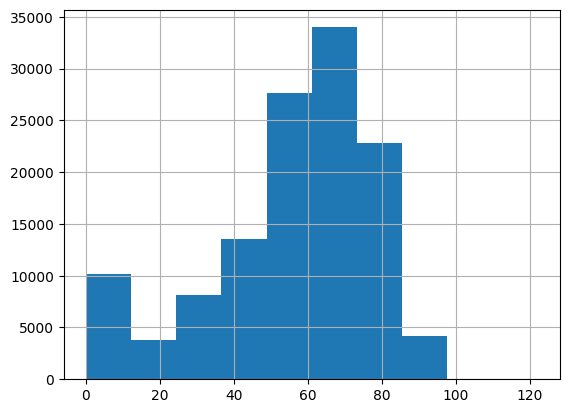

In [106]:
df_full["age"].hist()

<Axes: >

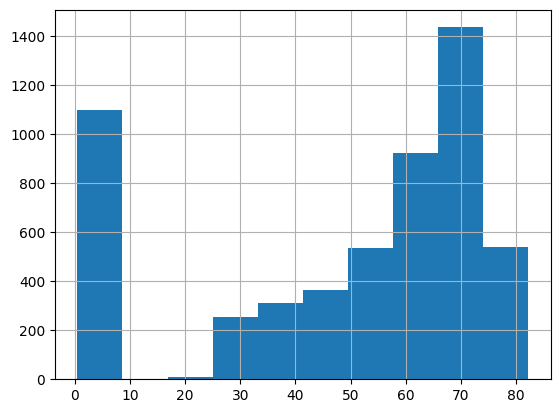

In [107]:
pd.Series(test_pred).hist()

In [108]:
test_pred.shape

(5475,)

In [109]:
test_pred

array([ 0.53002977,  4.56568289,  4.57860327, ..., 50.88559723,
       50.55439377, 52.95586395])

## Submission

In [110]:
submission = pd.read_csv(CFG.dataset_root_path + "submission.csv")
submission["AGE"] = test_pred
submission.to_csv(architecture_path + f"{architecture_name}_submission.csv", index=False)

In [111]:
submission

,FILENAME,GENDER,AGE
0,ecg_child_8781,FEMALE,0.530030
1,ecg_child_8782,MALE,4.565683
2,ecg_child_8783,MALE,4.578603
3,ecg_child_8784,FEMALE,5.242107
4,ecg_child_8785,FEMALE,0.534063
...,...,...,...
5470,ecg_adult_39536,FEMALE,32.544312
5471,ecg_adult_39537,FEMALE,58.087837
5472,ecg_adult_39538,FEMALE,50.885597
5473,ecg_adult_39539,FEMALE,50.554394
